In [158]:
from datasets import load_dataset
data = load_dataset("../data/6-parameter-maps/6-parameter-maps.py", cache_dir="/pscratch/sd/s/shubh/")

# id2label = {id:label for id, label in enumerate(data["train"].features) if label != "map"}
id2label = {id:label for id, label in enumerate(["Omega_m", "sigma_8"])}
label2id = {label:id for id,label in id2label.items()}
id2label, label2id

  0%|          | 0/3 [00:00<?, ?it/s]

({0: 'Omega_m', 1: 'sigma_8'}, {'Omega_m': 0, 'sigma_8': 1})

In [159]:
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

size = (224, 224)

print(size)

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=0, std=1)

train_data_augmentation = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_data_augmentation = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Omega_m", "sigma_8"]]).astype(np.float32)
    examples['pixel_values'] = [train_data_augmentation(image) for image in examples['map']]
    return examples

def preprocess_val(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Omega_m", "sigma_8"]]).astype(np.float32)
    examples['pixel_values'] = [val_data_augmentation(image) for image in examples['map']]
    return examples

data["train"].set_transform(preprocess_train)
data["validation"].set_transform(preprocess_val)
data["test"].set_transform(preprocess_val)

(224, 224)


In [160]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(data["train"], collate_fn=collate_fn, batch_size=32)
val_dataloader = DataLoader(data["validation"], collate_fn=collate_fn, batch_size=32)

# batch = next(iter(train_dataloader))
# for k,v in batch.items():
#     if isinstance(v, torch.Tensor):
#         print(k, v.shape)

In [161]:
import torch
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /global/homes/s/shubh/.cache/torch/hub/pytorch_vision_v0.10.0


In [162]:
from torch import nn
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(id2label), bias=True)
def dropout(model, rate):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            dropout(module, rate)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate))
            setattr(model, name, new)

dropout(model, 0.1)

In [163]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)

In [148]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): Dropout2d(p=0.1, inplace=False)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
 

In [164]:
import tqdm

device = torch.device("cuda:0")

def train_model(model, 
                data_loader, 
                val_data_loader,
                dataset_size, 
                val_size, 
                optimizer, 
                num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()

        running_loss = 0.0
        # Iterate over data.
        for bi, d in enumerate(tqdm.tqdm(data_loader)):
            inputs = d["pixel_values"]
            labels = d["labels"]
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / dataset_size
        print('Loss: {:.4f}'.format(epoch_loss))
        
        model.eval()
        running_loss = 0.0
        # Iterate over data.
        for bi, d in enumerate(tqdm.tqdm(val_data_loader)):
            inputs = d["pixel_values"]
            labels = d["labels"]
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_loss / val_size
        print('Val Loss: {:.4f}'.format(epoch_val_loss))
    return model

In [165]:
from transformers import AdamW

learning_rate = 0.001
weight_decay_rate = 0.0001

optimizer = AdamW(model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay_rate)

In [166]:
model = train_model(model, train_dataloader, val_dataloader, len(data["train"]), len(data["validation"]), optimizer, 10)

Epoch 0/9
----------


100%|██████████| 2500/2500 [02:50<00:00, 14.70it/s]


Loss: 0.0151


100%|██████████| 313/313 [00:09<00:00, 33.03it/s]


Val Loss: 0.0067
Epoch 1/9
----------


100%|██████████| 2500/2500 [02:47<00:00, 14.97it/s]


Loss: 0.0074


100%|██████████| 313/313 [00:09<00:00, 34.65it/s]


Val Loss: 0.0049
Epoch 2/9
----------


100%|██████████| 2500/2500 [02:46<00:00, 15.02it/s]


Loss: 0.0067


100%|██████████| 313/313 [00:09<00:00, 33.96it/s]


Val Loss: 0.0112
Epoch 3/9
----------


100%|██████████| 2500/2500 [02:45<00:00, 15.10it/s]


Loss: 0.0062


100%|██████████| 313/313 [00:09<00:00, 34.62it/s]


Val Loss: 0.0128
Epoch 4/9
----------


100%|██████████| 2500/2500 [02:46<00:00, 15.01it/s]


Loss: 0.0057


100%|██████████| 313/313 [00:09<00:00, 34.75it/s]


Val Loss: 0.0054
Epoch 5/9
----------


100%|██████████| 2500/2500 [02:50<00:00, 14.62it/s]


Loss: 0.0052


100%|██████████| 313/313 [00:10<00:00, 30.49it/s]


Val Loss: 0.0068
Epoch 6/9
----------


100%|██████████| 2500/2500 [02:57<00:00, 14.06it/s]


Loss: 0.0050


100%|██████████| 313/313 [00:09<00:00, 31.64it/s]


Val Loss: 0.0052
Epoch 7/9
----------


100%|██████████| 2500/2500 [02:56<00:00, 14.15it/s]


Loss: 0.0047


100%|██████████| 313/313 [00:10<00:00, 29.89it/s]


Val Loss: 0.0049
Epoch 8/9
----------


100%|██████████| 2500/2500 [02:58<00:00, 14.02it/s]


Loss: 0.0043


100%|██████████| 313/313 [00:10<00:00, 29.67it/s]


Val Loss: 0.0050
Epoch 9/9
----------


100%|██████████| 2500/2500 [02:56<00:00, 14.18it/s]


Loss: 0.0043


100%|██████████| 313/313 [00:10<00:00, 29.52it/s]

Val Loss: 0.0053


In [168]:
del inputs

In [169]:
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

6138587136
6138587136


In [170]:
n_pred = 10

preds = np.empty((n_pred, len(data["validation"]), 2))
label_ids = []

val_dataloader = DataLoader(data["validation"], collate_fn=collate_fn, batch_size=32)

for i in range(n_pred):
    if i % 2 == 0: 
        print(i)
    ps = []
    model.train()
    for bi, d in enumerate(tqdm.tqdm(val_dataloader)):
        inputs = d["pixel_values"]
        inputs = inputs.to(device, dtype=torch.float)
        outputs = model(inputs)
        if i == 0:
            label_ids += d["labels"]
        preds[i, bi*32 : (1+bi)*32] = outputs.detach().cpu().numpy()
        
label_ids = torch.stack(label_ids)
preds, label_ids

0


100%|██████████| 313/313 [00:10<00:00, 29.11it/s]


2


100%|██████████| 313/313 [00:10<00:00, 29.11it/s]


4


100%|██████████| 313/313 [00:10<00:00, 29.17it/s]


6


100%|██████████| 313/313 [00:10<00:00, 29.33it/s]


8


100%|██████████| 313/313 [00:10<00:00, 29.19it/s]


(array([[[0.29701483, 0.50166863],
         [0.23985735, 1.18548632],
         [0.38608402, 0.77173948],
         ...,
         [0.19228756, 1.21532965],
         [0.21929562, 0.66619861],
         [0.40383139, 0.59645325]],
 
        [[0.28544864, 0.50760496],
         [0.25786829, 1.16499555],
         [0.4172157 , 0.75858057],
         ...,
         [0.22799684, 1.20570707],
         [0.21230769, 0.68219054],
         [0.40956122, 0.55526507]],
 
        [[0.2547124 , 0.52248359],
         [0.23826133, 1.22470748],
         [0.39915329, 0.76285517],
         ...,
         [0.21939857, 1.21572959],
         [0.17523068, 0.71201074],
         [0.42733416, 0.58946538]],
 
        ...,
 
        [[0.29322946, 0.50521493],
         [0.2437764 , 1.16113389],
         [0.39314049, 0.81183201],
         ...,
         [0.20827864, 1.20620275],
         [0.21683703, 0.65971947],
         [0.38824919, 0.61405063]],
 
        [[0.29718632, 0.48283619],
         [0.23549217, 1.09792876],
       

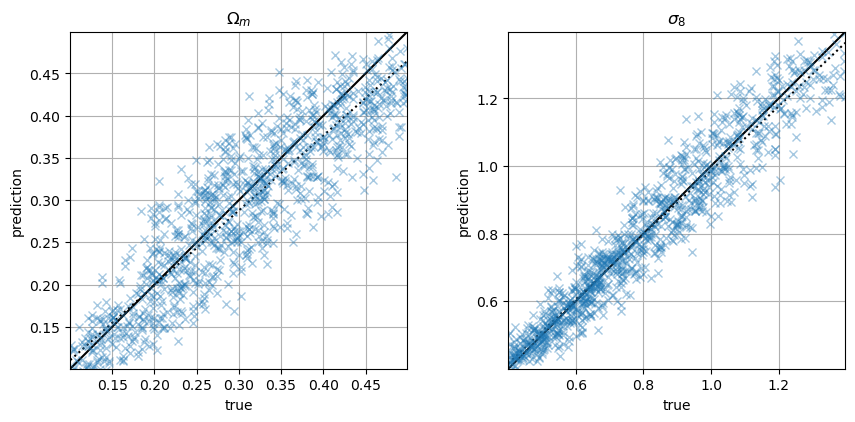

In [172]:
plot_y = label_ids
predictions_best = np.nanmean(preds, axis=0)
predictions_std = np.nanstd(preds, axis=0)

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions_best[:, ind], 1))
    # ax.errorbar(plot_y[:, ind][::10], predictions_best[:, ind][::10],  predictions_std[:, ind][::10], marker="x", ls='none', alpha=0.4)
    ax.errorbar(plot_y[:, ind][::10], predictions_best[:, ind][::10],  0, marker="x", ls='none', alpha=0.4)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()

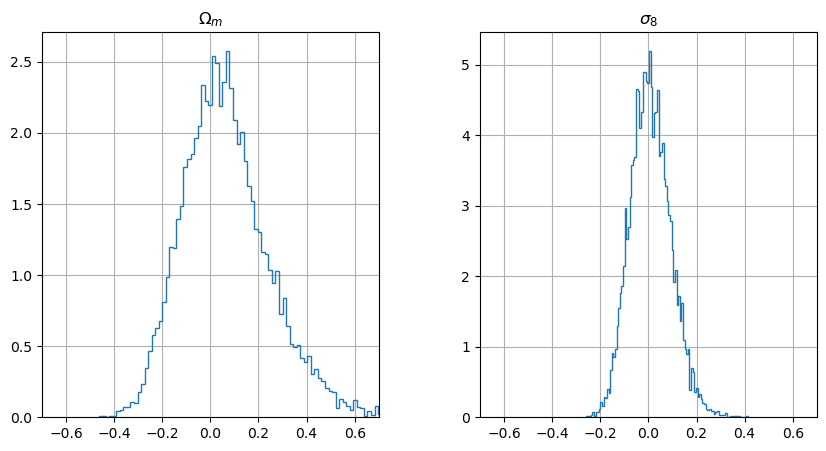

In [177]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax) in enumerate(zip(labels, axs.ravel())):
    ax.hist((plot_y[:, ind] - predictions_best[:, ind]) / predictions_best[:, ind], bins=100, density=True, histtype="step")
    ax.set_title(label)
    ax.set_xlim([-0.7, 0.7])
    ax.grid()
plt.show()
plt.close()

In [178]:
indexes = [5056, 8110, 3840, 1028, 7385]

0


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


[0.18261719 0.88779294]
[0.44228075 0.23706046] [0.43235153 0.25198117]


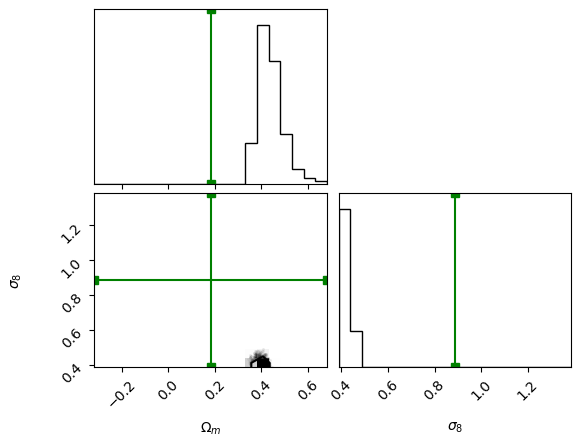

1


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


[0.4408203 0.5977539]
[0.44228075 0.23706046] [0.43235153 0.25198117]


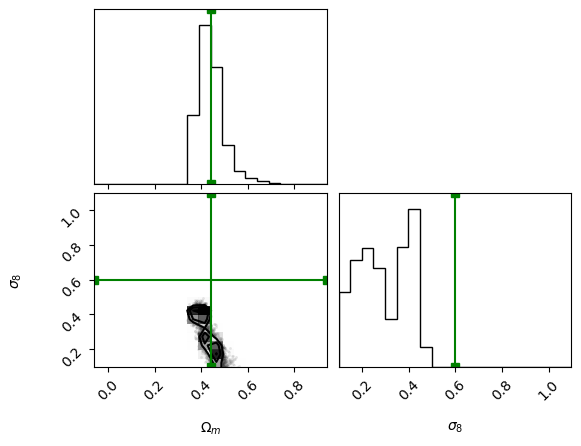

2


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


[0.3953125 0.8179687]
[0.44228075 0.23706046] [0.43235153 0.25198117]


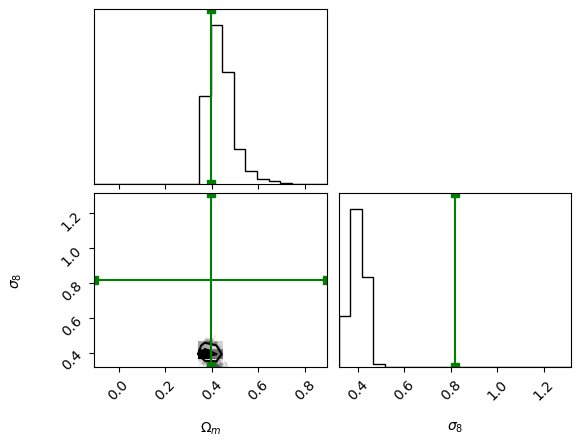

3


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


[0.37441406 0.46689454]
[0.44228075 0.23706046] [0.43235153 0.25198117]


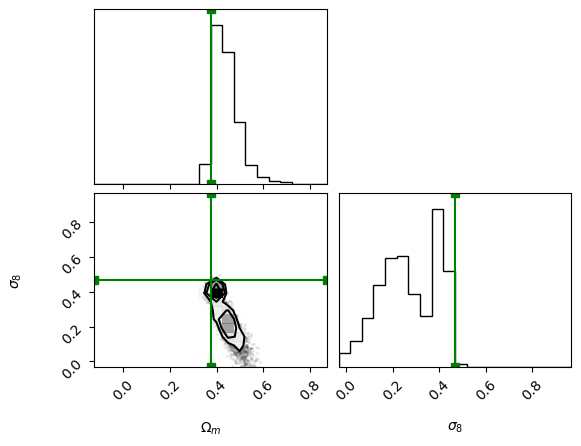

4


100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


[0.17050782 1.1329101 ]
[0.44228075 0.23706046] [0.43235153 0.25198117]


ValueError: It looks like the provided 'range' is not valid or the sample is empty.

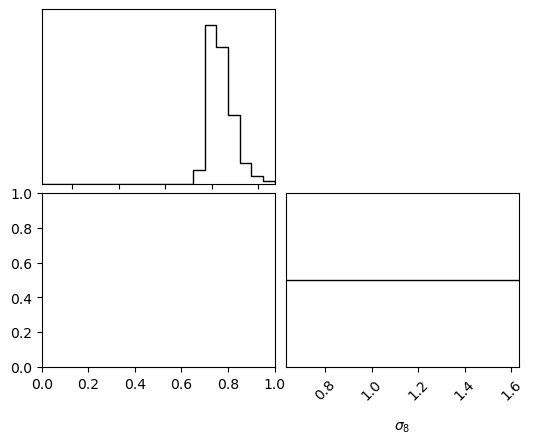

In [179]:
from datasets import Dataset
import corner 

n_pred = 1001

for ind in range(5):
    print(ind)
    preds = np.empty((n_pred, 2))
    index = indexes[ind]
    data_repeat = {}
    for key, val in data["validation"][index:index+1].items():
        if key == "labels":
            data_repeat[key] = np.repeat(val, n_pred, axis=0)
            continue
        data_repeat[key] = val * n_pred    
    datapoint = Dataset.from_dict(data_repeat)
    datapoint.set_transform(preprocess_val)

    val_dataloader = DataLoader(datapoint, collate_fn=collate_fn, batch_size=32)

    model.train()
    for bi, d in enumerate(tqdm.tqdm(val_dataloader)):
        inputs = d["pixel_values"]
        inputs = inputs.to(device, dtype=torch.float)
        outputs = model(inputs)
        preds[bi*32 : (1+bi)*32] = outputs.detach().cpu().numpy()
    
    labels = lab_x, lab_y = data["validation"][index:index+1]["labels"][0]
    margin = 5e-1
    print(labels)
    print(np.nanmean(preds_one, axis=0), np.nanmedian(preds_one, axis=0))
    fig = plt.figure()
    corner.corner(preds_one, fig=fig, labels=[r"$\Omega_m$", r"$\sigma_8$"], \
                  range=[(lab_x-margin, lab_x+margin), (lab_y-margin, lab_y+margin)])
    corner.overplot_lines(fig, labels, marker="s", color="green")
    plt.show()
    plt.close()